Learn iterator for thermal problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from feanet.iterator import PsiNet
from feanet.iterator import PsiIterator
from data.dataset import MechanicalDataSet

In [4]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
n_elem = 2**5 # element size on the edge
nb_layers = 3
bs = 5

no_neumann_train = True # not considering Neumann bc for training
no_neumann_test = False # not considering Neumann bc for testing
train = False # True or False
model_name = 'dirich_33x33_smoother'
model_dir = 'model/learn_iterator/thermal'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [6]:
training_set = MechanicalDataSet('data/data_thermal/dirich_plate_train_33x33.h5', device)
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
elem_mask_train, node_mask_train, dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, neumann_conn_train, material_train, f_train, u_train = next(iter(train_dataloader))

test_set = MechanicalDataSet('data/data_thermal/neumann_plate_test_33x33.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))

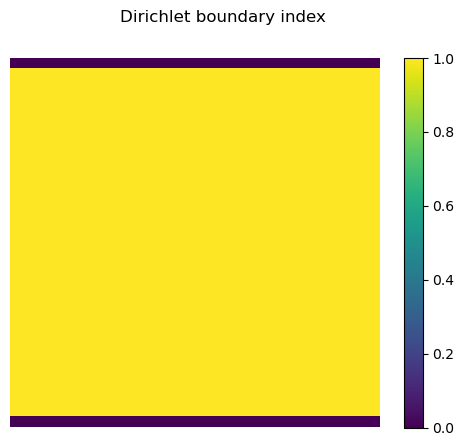

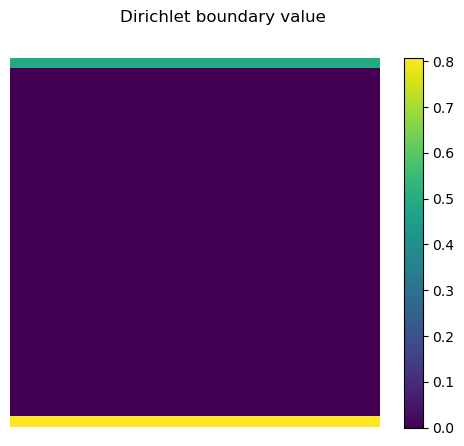

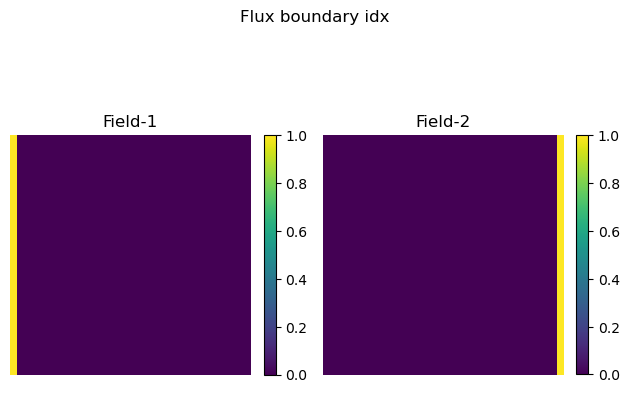

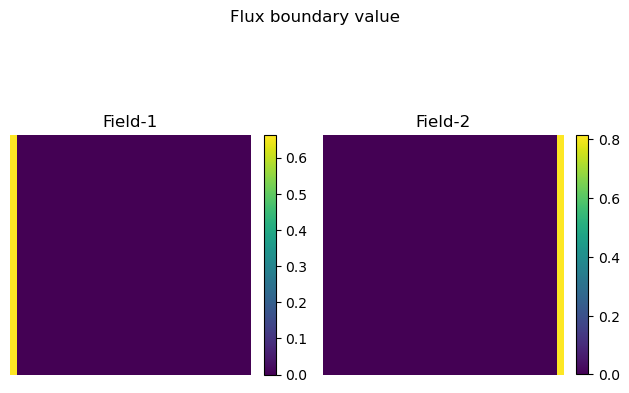

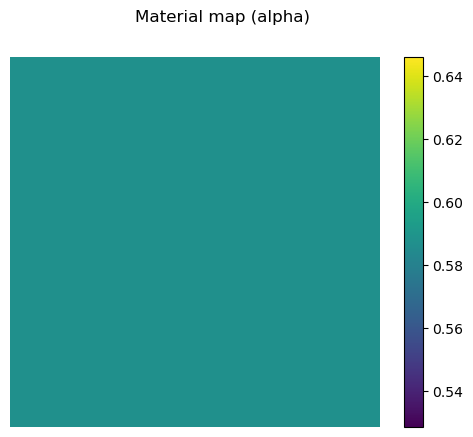

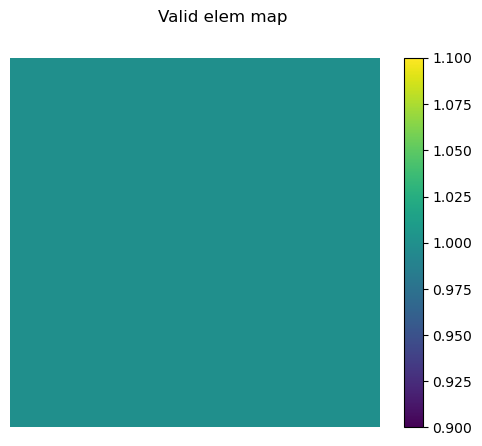

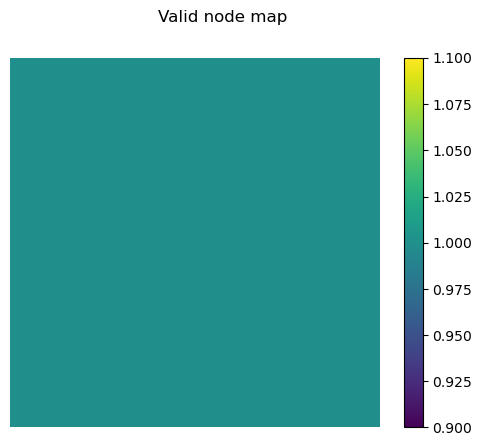

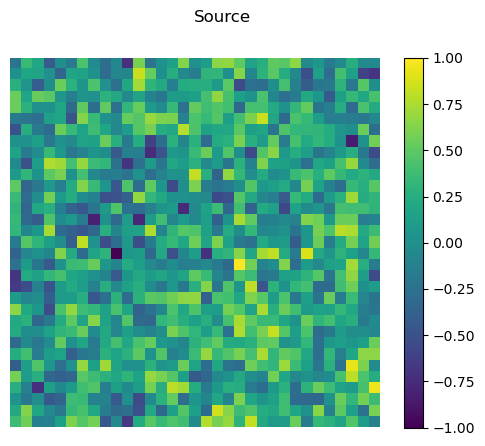

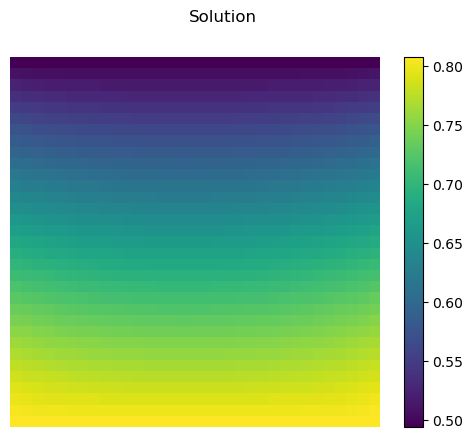

In [7]:
k = 0 # the index of test data to be shown
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Flux boundary idx')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

Create a set of solution data for testing purpose

In [8]:
solution_test, rhs_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

Test using single grid FEA-Net

In [9]:
hsize = 2e-3 # m
ku, kf = 1, 1
grid = SingleGrid(hsize, n_elem=n_elem, mode='thermal', dev=device_predict, no_neumann=no_neumann_test)

0 1.7848030136858986
1 0.9973792560951632
2 0.7224189189829301
3 0.5770104986516867
4 0.48545931132825537
5 0.42186347491978926
6 0.37479093263219315
7 0.33836281167610355
8 0.3092270268510839
9 0.28532361912657933
10 0.2653124813844288
11 0.24828180606005434
12 0.23358827540225421
13 0.2207641905335588
14 0.20946085445031318
15 0.19941264913502346
16 0.19041345698186732
17 0.18230072713111342
18 0.17494443192714887
19 0.16823924078759364
20 0.1620988640755821
21 0.15645189308075153
22 0.1512386919508687
23 0.14640904245034173
24 0.141920336146835
25 0.137736170483272
26 0.13382524680180022
27 0.13016049686594452
28 0.12671838423206
29 0.12347834079600777
30 0.12042230883589702
31 0.11753436611033244
32 0.11480041687575518
33 0.11220793561597013
34 0.10974575321820997
35 0.10740387755300795
36 0.10517334211045622
37 0.1030460776493361
38 0.10101480282640263
39 0.09907293056241168
40 0.09721448752200057
41 0.095434044575384
42 0.09372665650033558
43 0.09208780949523085
44 0.090513375324

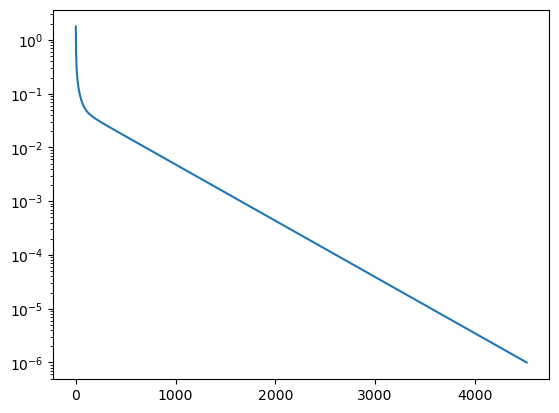

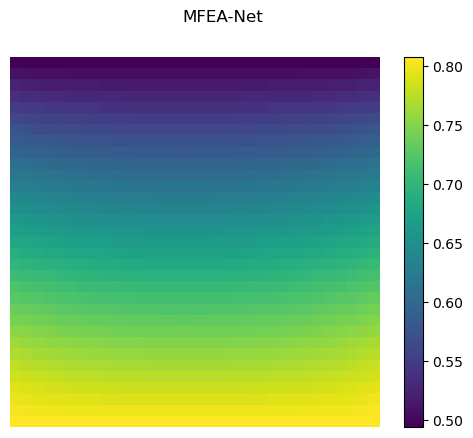

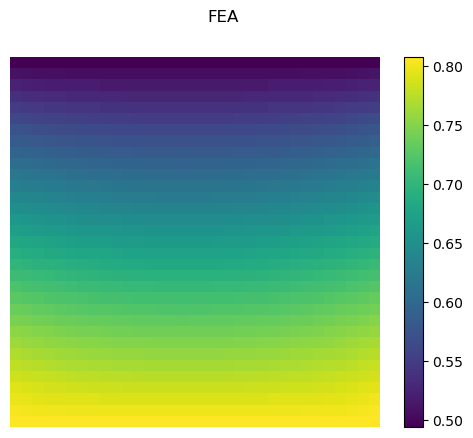

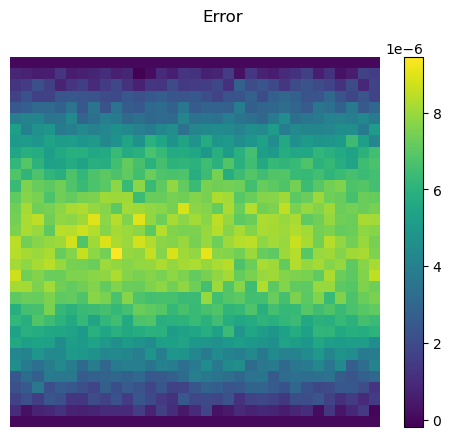

In [10]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(True):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test)
        residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_thermalfield(jacu_test[0], "MFEA-Net")
    plot.plot_thermalfield(solution_test[0], "FEA")
    plot.plot_thermalfield(jacu_test[0]-solution_test[0], 'Error')

In [11]:
max_epochs = 1000

if(train):
    my_iterator = PsiIterator(device, hsize, n_elem, no_neumann_train, batch_size=bs, mode='thermal', iterator='psi', nb_layers=nb_layers, max_epochs=max_epochs)
    loss_train = torch.zeros((max_epochs, 1))
    loss_train = my_iterator.Train(training_set, model_name, model_dir)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


Test the learned smoother

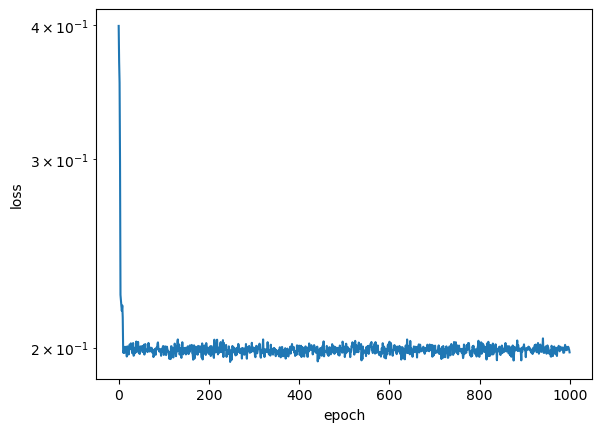

In [12]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, hsize, n_elem, no_neumann_test, psi_net=my_net, grid=grid, nb_layers=nb_layers, batch_size=1, iterator='psi')
my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

In [13]:
list(my_net.parameters())

[Parameter containing:
 tensor([[[[-0.2123, -0.0335, -0.1305],
           [-0.4624, -1.0278, -0.0401],
           [-0.2198, -0.0409, -0.1365]]]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[-0.1414, -0.1788, -0.2739],
           [-0.1422,  0.1062, -0.7521],
           [-0.1460, -0.1826, -0.2795]]]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[0.1495, 0.2918, 0.1406],
           [0.5748, 0.1638, 0.0724],
           [0.1504, 0.2931, 0.1441]]]], dtype=torch.float64, requires_grad=True)]

0 1.7848030136858986
1 0.362604060835119
2 0.17901441235044097
3 0.1280424500541261
4 0.10224787756592484
5 0.08610733875663992
6 0.07495352038320892
7 0.06682398432035547
8 0.0607108244206993
9 0.05601038741796658
10 0.05232148034740642
11 0.049363151366044584
12 0.0469350056185655
13 0.04489378891040664
14 0.043137388130802014
15 0.041593209942228704
16 0.040209661887760324
17 0.03894997366483984
18 0.03778778075299847
19 0.0367040080191061
20 0.03568469139874749
21 0.03471946438037582
22 0.03380050933910654
23 0.032921830899106316
24 0.03207875108398864
25 0.03126755676535289
26 0.030485251641701135
27 0.02972938008859379
28 0.028997900616690775
29 0.028289093774418527
30 0.027601494157631936
31 0.026933839458921967
32 0.026285031702849942
33 0.025654107312284426
34 0.02504021366777255
35 0.024442590513938683
36 0.023860555040238346
37 0.02329348978932092
38 0.022740832772558953
39 0.022202069331054845
40 0.021676725393136004
41 0.02116436186047116
42 0.020664569914162913
43 0.02017

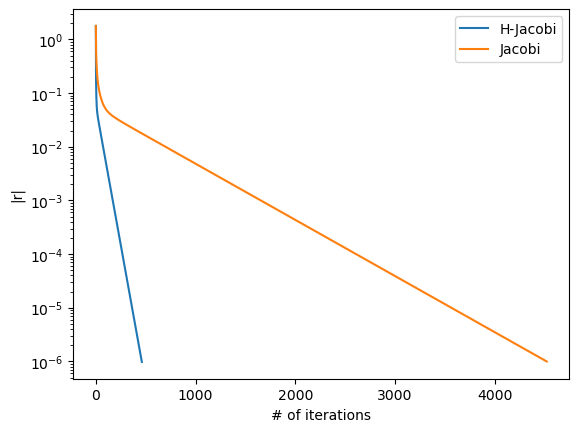

In [14]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS):
        u_test = new_iterator.PsiRelax(u_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test, 1)
        residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='H-Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.ylabel('|r|')
plt.xlabel('# of iterations')
plt.yscale('log')
plt.legend()
plt.savefig('results/jac_res.jpg', dpi=500, bbox_inches='tight')
plt.show()

In [15]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

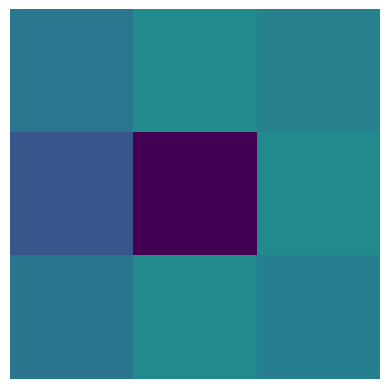

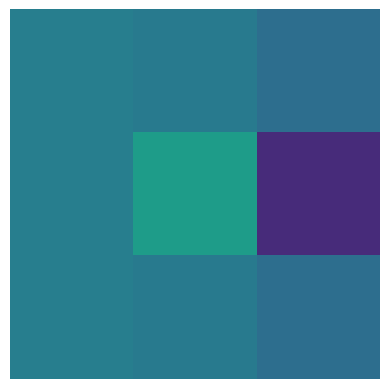

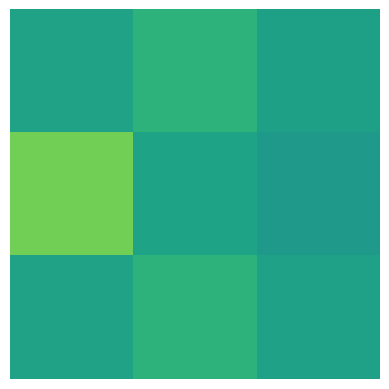

In [16]:
# plot the kernels
mlist = list(my_net.cpu().parameters())
heatmap2d(mlist[0].view(3,3).detach().numpy(),fname='results/kernel1.jpg', cbar=False)
heatmap2d(mlist[1].view(3,3).detach().numpy(),fname='results/kernel2.jpg', cbar=False)
heatmap2d(mlist[2].view(3,3).detach().numpy(),fname='results/kernel3.jpg', cbar=False)

In [17]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [18]:
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)

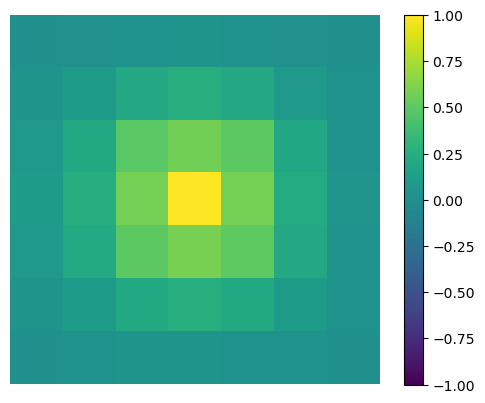

In [19]:
heatmap2d(kernel2.view(7,7).detach().numpy(),fname='results/kernel_comb.jpg')

In [20]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(hsize, n, no_neumann_test, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 1.7848030136858986
1 0.3984916756073593
2 0.09766666430714725
3 0.024170918591947047
4 0.006022631991072927
5 0.0015094382421372051
6 0.0003802796708820471
7 9.625822267807257e-05
8 2.4470924568732722e-05
9 6.245994092309879e-06
10 1.600200105288962e-06
11 4.114036309134919e-07
Solution converges after 11 Jacobi multigrid iterations in 0.033882856369018555 seconds.


In [21]:
with torch.no_grad():
    n = n_elem
    n_mg_psi = 0
    mg_psi = MultiGrid(hsize, n, no_neumann_test, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='psi') # create a multigrid model
    mg_psi.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_psi = mg_psi.iterators[0].grid.jac.reset_boundary(u_mg_psi, d_test, d_idx_test)
    residual = mg_psi.iterators[0].grid.net(None, None, hsize, u_mg_psi, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_psi, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_psi.Step(u_mg_psi)
        residual = mg_psi.iterators[0].grid.net(None, None, hsize, u_mg_psi, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_psi += 1
        print(n_mg_psi, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_psi, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 1.7848030136858986
1 0.034823167520399656
2 0.0020056999749539666
3 0.0001738625082883151
4 1.6758979224093675e-05
5 1.650464990606471e-06
6 1.6443499382491443e-07
Solution converges after 6 Psi-Jacobi multigrid iterations in 0.02650308609008789 seconds.


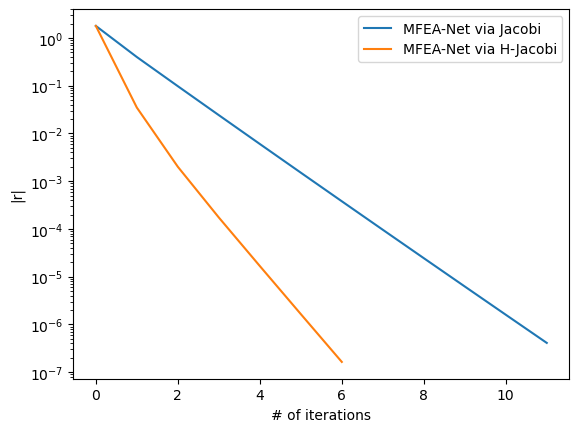

In [22]:
plt.plot(res_arr_mgjac, label='MFEA-Net via Jacobi')
plt.plot(res_arr_mgpsi, label='MFEA-Net via H-Jacobi')
plt.yscale('log')
plt.legend()
plt.ylabel('|r|')
plt.xlabel('# of iterations')
plt.savefig('results/multigrid_res.jpg', dpi=500, bbox_inches='tight')
plt.show()

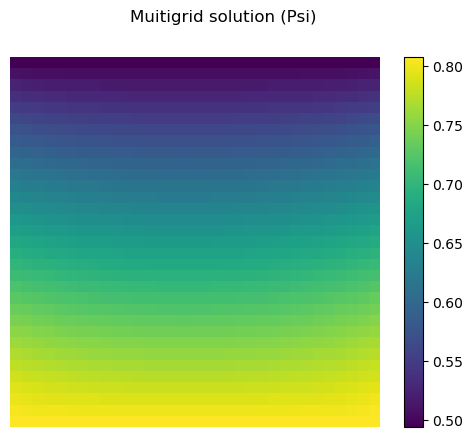

In [23]:
plot.plot_thermalfield((u_mg_psi).reshape(n+1,n+1), 'Muitigrid solution (Psi)')

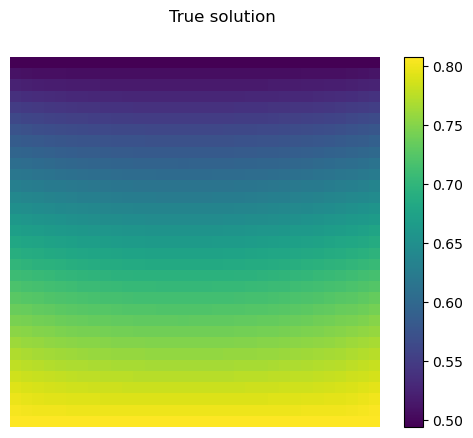

In [24]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

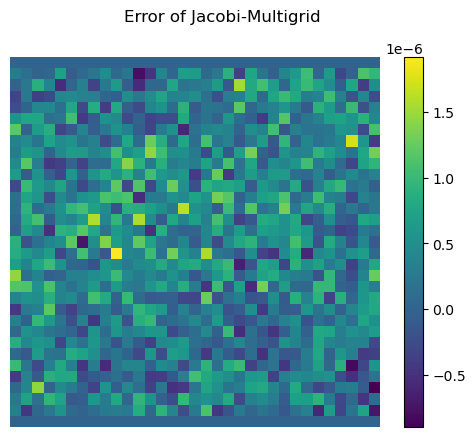

In [25]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

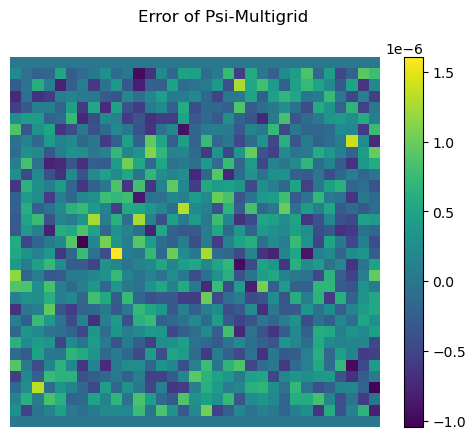

In [26]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')